In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [8]:
##Choosing only the acute care hospitals this time
master_data = pd.read_csv("Hospital General Information.csv", encoding="latin-1",
                         usecols=["Provider ID", "Hospital overall rating", "Hospital Type"])
master_data = master_data.loc[master_data["Hospital overall rating"] != "Not Available"]
master_data = master_data.loc[master_data["Hospital Type"] == "Acute Care Hospitals"]
master_data["Hospital overall rating"] = master_data["Hospital overall rating"].astype(int)
master_data.head()

,Provider ID,Hospital Type,Hospital overall rating
0,10001,Acute Care Hospitals,3
1,10005,Acute Care Hospitals,3
2,10006,Acute Care Hospitals,2
3,10007,Acute Care Hospitals,3
4,10008,Acute Care Hospitals,3


So, data folder contains files with more details on measures used for each of the group variable used for getting the rating.

Let's load them one by one and analyzie them.

### Mortality and readmissionns

In [9]:
df_mort_readm = pd.read_csv("Readmissions and Deaths - Hospital.csv")
df_mort_readm.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Morta...,MORT_30_AMI,No Different than the National Rate,733,12.5,10.6,14.9,NaN,07/01/2012,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for CABG,MORT_30_CABG,No Different than the National Rate,278,4.2,2.6,6.8,NaN,07/01/2012,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for chronic obstructive pulmonary d...,MORT_30_COPD,No Different than the National Rate,586,9.3,7.3,11.8,NaN,07/01/2012,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart failure (HF) 30-Day Mortality Rate,MORT_30_HF,No Different than the National Rate,797,12.4,10.4,14.6,NaN,07/01/2012,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Pneumonia (PN) 30-Day Mortality Rate,MORT_30_PN,No Different than the National Rate,599,15.5,13.0,18.5,NaN,07/01/2012,06/30/2015


Since this dataframe contains information on both mortality and readmissions, we break it into two separate dataframes.

In [15]:
#We observe that mortality measure IDs have the "MORT" keyword
#whereas readmission measure IDs have the "READM" keyword
#We'll use it to segregate the data
df_mort = df_mort_readm.loc[df_mort_readm["Measure ID"].str.contains("MORT")]
df_readm = df_mort_readm.loc[df_mort_readm["Measure ID"].str.contains("READM")]
print(df_mort.shape, df_readm.shape)

(28908, 18) (38544, 18)


In [16]:
print("Unique Measure for mortality", df_mort["Measure Name"].nunique())
df_mort["Measure Name"].unique()

Unique Measure for mortality 6


array(['Acute Myocardial Infarction (AMI) 30-Day Mortality Rate',
       'Death rate for CABG',
       'Death rate for chronic obstructive pulmonary disease (COPD) patients',
       'Heart failure (HF) 30-Day Mortality Rate',
       'Pneumonia (PN) 30-Day Mortality Rate',
       'Death rate for stroke patients'], dtype=object)

We can restructure dataframe such that each row represents hospital and different columns are scores on different measure id's.

In [17]:
#Restructure data with only the measureID and the scores
df_mort = df_mort.pivot_table(index="Provider ID", columns=["Measure ID"],
                                     values=["Score"], aggfunc='last')
df_mort.columns = df_mort.columns.map("{0[1]}_{0[0]}".format)
df_mort.head()

,MORT_30_AMI_Score,MORT_30_CABG_Score,MORT_30_COPD_Score,MORT_30_HF_Score,MORT_30_PN_Score,MORT_30_STK_Score
Provider ID,,,,,,
10001,12.5,4.2,9.3,12.4,15.5,15.4
10005,16.0,Not Available,7.6,15.5,20.8,15.5
10006,16.7,4.1,7.1,15.6,18.2,17.9
10007,Not Available,Not Available,9.3,14.4,18.8,16.6
10008,Not Available,Not Available,8.2,12.7,15.7,Not Available


In [18]:
# Check percent nulls in all measure scores
df_mort = df_mort.replace("Not Available", np.nan)
df_mort = df_mort.astype(float)
df_mort.isnull().mean()

MORT_30_AMI_Score     0.504359
MORT_30_CABG_Score    0.784558
MORT_30_COPD_Score    0.254670
MORT_30_HF_Score      0.249066
MORT_30_PN_Score      0.151515
MORT_30_STK_Score     0.444583
dtype: float64

* There are lot of missing scores specially for CABG measure

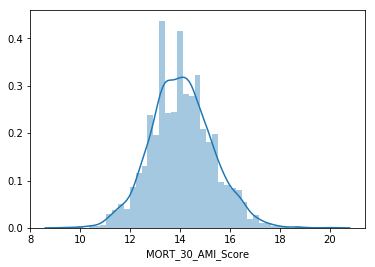

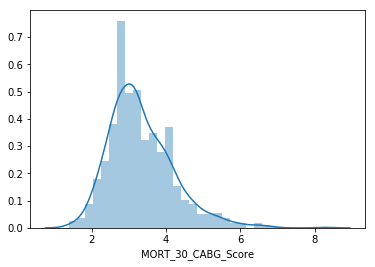

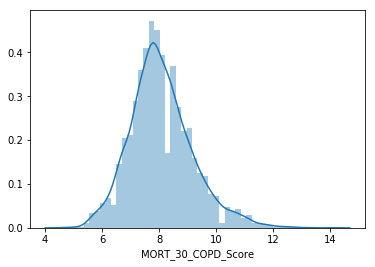

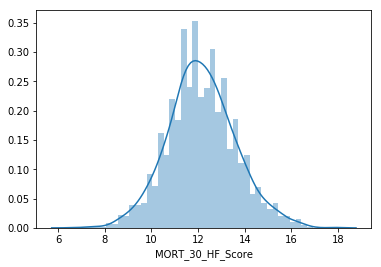

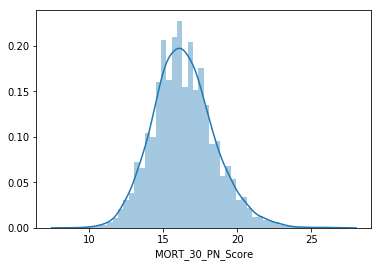

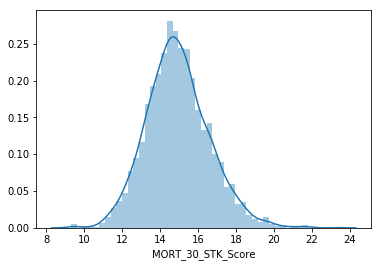

In [19]:
for col in df_mort.columns:
    sns.distplot(df_mort[col].dropna())
    plt.show()

Distributions of all the scores after removing null values is approximately normal. 

We can merge this data with master data to check their impact on overall score.

In [20]:
mort_measures = df_mort.columns
df_mort = master_data.join(df_mort, on="Provider ID")
df_mort.head()

,Provider ID,Hospital Type,Hospital overall rating,MORT_30_AMI_Score,MORT_30_CABG_Score,MORT_30_COPD_Score,MORT_30_HF_Score,MORT_30_PN_Score,MORT_30_STK_Score
0,10001,Acute Care Hospitals,3,12.5,4.2,9.3,12.4,15.5,15.4
1,10005,Acute Care Hospitals,3,16.0,NaN,7.6,15.5,20.8,15.5
2,10006,Acute Care Hospitals,2,16.7,4.1,7.1,15.6,18.2,17.9
3,10007,Acute Care Hospitals,3,NaN,NaN,9.3,14.4,18.8,16.6
4,10008,Acute Care Hospitals,3,NaN,NaN,8.2,12.7,15.7,NaN


We break the rating into 3 groups for ease of visualization:
    * group 0: ratings 1 and 2 - low
    * group 1: ratings 3 - average
    * group 2: ratings 4 and 5 - high
 

In [21]:
rating_group_map = {1: 0, 2: 0, 3: 1, 4: 2, 5: 2}
df_mort["rating_group"] = df_mort["Hospital overall rating"].map(rating_group_map).astype(float)

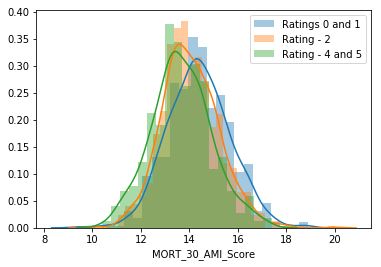

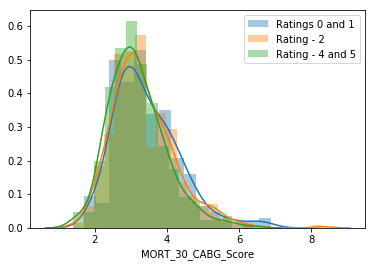

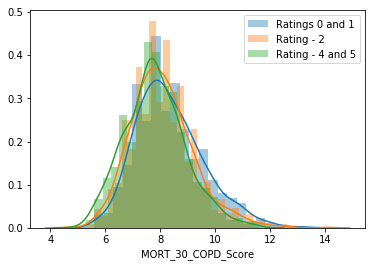

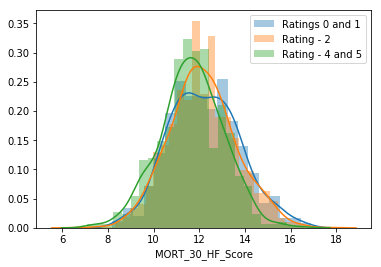

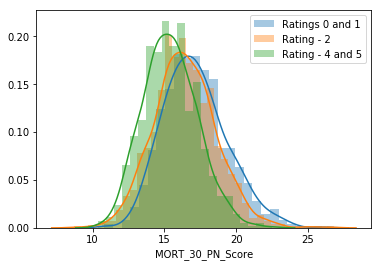

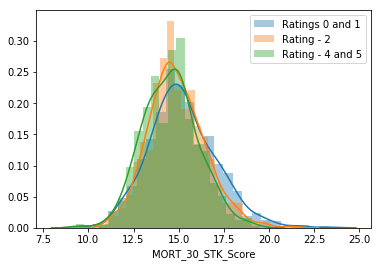

In [22]:
for measure in mort_measures:
    sns.distplot(df_mort.loc[df_mort["rating_group"] == 0, measure].dropna())
    sns.distplot(df_mort.loc[df_mort["rating_group"] == 1, measure].dropna())    
    sns.distplot(df_mort.loc[df_mort["rating_group"] == 2, measure].dropna())
    plt.legend(["Ratings 0 and 1", "Rating - 2", "Rating - 4 and 5"])
    plt.show()

**Mort_30_PN and MORT_30_AMI are two most important measures as their distributions can easily be separated for different ratings**

**All the measures are negatively corelated with rating, so we multiply them by -1 so that all measure translate to higher the better**

We can repeat this analysis for other group parameters and also get additional data for modelling. We can write methods to automate some of the tasks

In [23]:
measures = ['MORT_30_AMI_Score', 'MORT_30_CABG_Score', 'MORT_30_COPD_Score',
       'MORT_30_HF_Score', 'MORT_30_PN_Score', 'MORT_30_STK_Score']
df_mort[measures] = -1* df_mort[measures]

In [24]:
rating_group_map = {1: 0, 2: 0, 3: 1, 4: 2, 5: 2}
master_data["rating_group"] = master_data["Hospital overall rating"].map(rating_group_map).astype(float)


def pivot_data(df, measure_col, score_col):
    df = df.loc[df[score_col] != "Not Available"]
    df = df.pivot_table(index="Provider ID", columns=[measure_col],
                                     values=[score_col], aggfunc='last')
    df.columns = df.columns.map("{0[1]}_{0[0]}".format)
    return df

def plot_distributions(df):
    for col in df.columns:
        sns.distplot(df[col].dropna())
        plt.show()

def plot_group_distributions(df, master_data):
    measure_cols = df.columns
    df = master_data.join(df, on="Provider ID")
    for measure in measure_cols:
        sns.distplot(df.loc[df["rating_group"] == 0, measure].dropna())
        sns.distplot(df.loc[df["rating_group"] == 1, measure].dropna())    
        sns.distplot(df.loc[df["rating_group"] == 2, measure].dropna())
        plt.legend(["Ratings 0 and 1", "Rating - 2", "Rating - 4 and 5"])
        plt.show()

In [25]:
df_readm = pivot_data(df_readm, measure_col="Measure ID", score_col="Score")
df_readm = df_readm.astype(float)

df_readm.head()

,READM_30_AMI_Score,READM_30_CABG_Score,READM_30_COPD_Score,READM_30_HF_Score,READM_30_HIP_KNEE_Score,READM_30_HOSP_WIDE_Score,READM_30_PN_Score,READM_30_STK_Score
Provider ID,,,,,,,,
10001,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7
10005,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4
10006,16.1,15.2,19.8,20.6,5.0,15.4,17.9,12.0
10007,NaN,NaN,19.9,21.1,NaN,16.6,17.3,12.7
10008,NaN,NaN,19.2,23.1,NaN,15.7,16.0,NaN


In [26]:
df_readm.isnull().mean()

READM_30_AMI_Score          0.510079
READM_30_CABG_Score         0.767384
READM_30_COPD_Score         0.173726
READM_30_HF_Score           0.173273
READM_30_HIP_KNEE_Score     0.381427
READM_30_HOSP_WIDE_Score    0.004530
READM_30_PN_Score           0.073839
READM_30_STK_Score          0.409287
dtype: float64

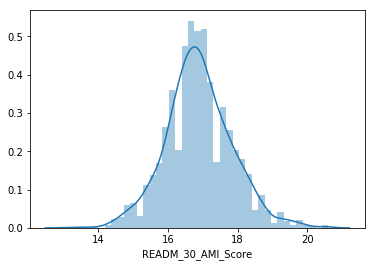

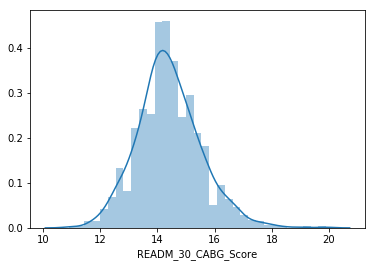

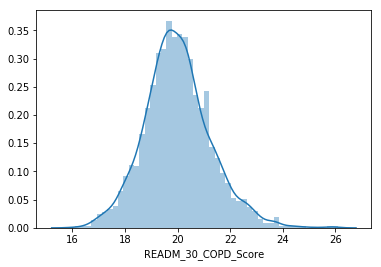

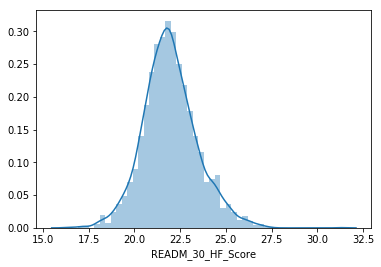

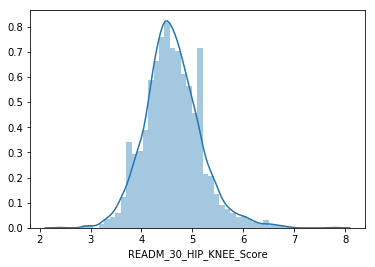

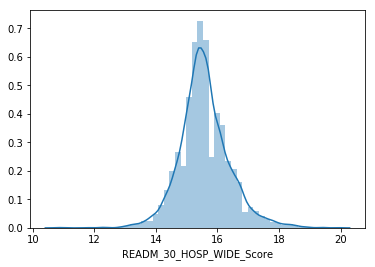

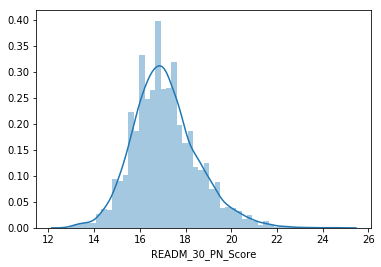

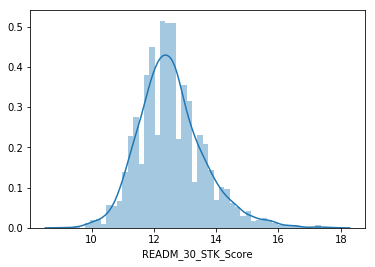

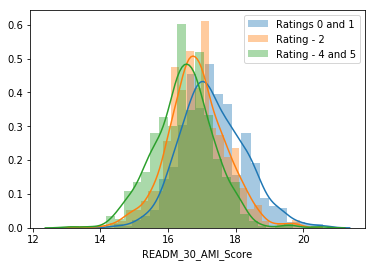

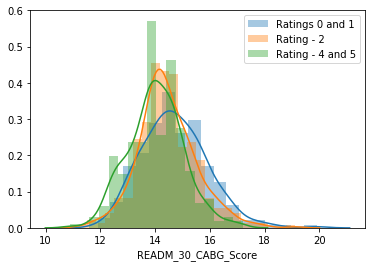

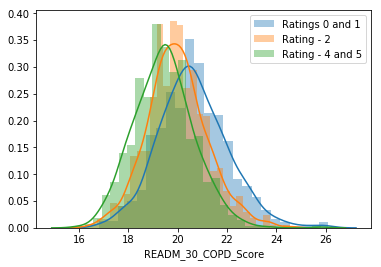

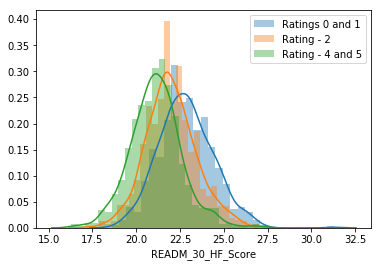

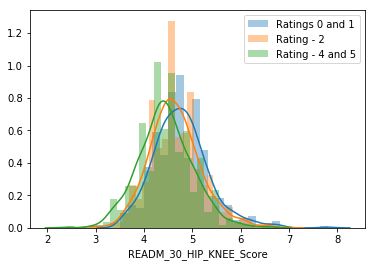

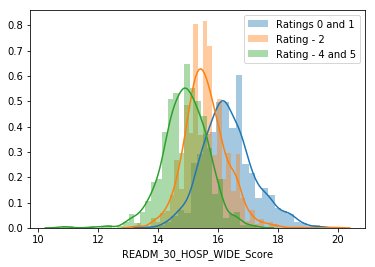

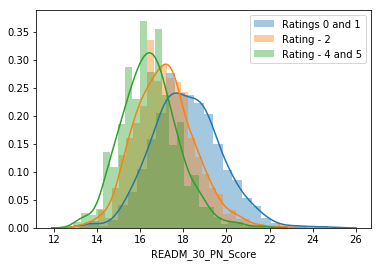

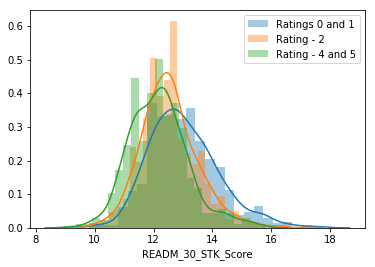

In [27]:
plot_distributions(df_readm)
plot_group_distributions(df_readm, master_data)

### Observations:

* Most of the measures in readmissions clearly separate different rating groups and are important features
* All measures on readmissions are again negatively corelated so we invert them
* WIDE, PN and HF are most important measures

In [28]:
df_readm  = -1*df_readm
df_readm.head()

,READM_30_AMI_Score,READM_30_CABG_Score,READM_30_COPD_Score,READM_30_HF_Score,READM_30_HIP_KNEE_Score,READM_30_HOSP_WIDE_Score,READM_30_PN_Score,READM_30_STK_Score
Provider ID,,,,,,,,
10001,-16.5,-15.1,-21.1,-21.4,-5.1,-15.4,-18.7,-12.7
10005,-16.7,NaN,-18.0,-21.9,-5.7,-14.9,-16.4,-13.4
10006,-16.1,-15.2,-19.8,-20.6,-5.0,-15.4,-17.9,-12.0
10007,NaN,NaN,-19.9,-21.1,NaN,-16.6,-17.3,-12.7
10008,NaN,NaN,-19.2,-23.1,NaN,-15.7,-16.0,NaN


## Timeliness and Effectiveness

This has measures related to both timeliness and effectivess of care. SO we need to seprate them out

In [30]:
df_time_eff = pd.read_csv("Timely and Effective Care - Hospital.csv")
df_time_eff.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Condition,Measure ID,Measure Name,Score,Sample,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,AMI_7a,Fibrinolytic Therapy Received Within 30 Minute...,Not Available,Not Available,7 - No cases met the criteria for this measure.,01/01/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,AMI_8a,Primary PCI Received Within 90 Minutes of Hosp...,92,24,3 - Results are based on a shorter time period...,01/01/2015,09/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Children's Asthma,CAC_3,Home Management Plan of Care Document,Not Available,Not Available,5 - Results are not available for this reporti...,01/01/2015,12/31/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_1b,ED1,269,535,2 - Data submitted were based on a sample of c...,01/01/2015,12/31/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_2b,ED2,68,535,2 - Data submitted were based on a sample of c...,01/01/2015,12/31/2015


Check unique measures for timeliness. 

In [31]:
# Manually looking at all measures and braking them into timeliness and effectiveness
time_measures = ['Fibrinolytic Therapy Received Within 30 Minutes Of Hospital Arrival',
 'Fibrinolytic Therapy Received Within 30 Minutes of ED Arrival',
 'Median Time to ECG',
 'Median Time to Fibrinolysis',
 'Median Time to Transfer to Another Facility for Acute Coronary Intervention',
 'Median time to pain med', 
 'Primary PCI Received Within 90 Minutes of Hospital Arrival',
 'Prophylactic antibiotic received within 1 hour prior to surgical incision',
 'Prophylactic antibiotics discontinued within 24 hours after surgery end time',
 'Surgery Patients Who Received Appropriate Venous Thromboembolism Prophylaxis Within 24 Hours Prior to Surgery to 24 Hours After Surgery',
]

effective_measures = ['Anticoagulation Therapy for Atrial Fibrillation/Flutter',
 'Anticoagulation overlap therapy',
 'Antithrombotic Therapy by End of Hospital Day 2',
 'Aspirin at Arrival',
 'Assessed for Rehabilitation',
 'Discharged on Antithrombotic Therapy',
 'Discharged on Statin Medication',
 'Door to diagnostic eval',
 'ED1',
 'ED2',
 'Emergency department volume',
 'Endoscopy/polyp surveillance: appropriate follow-up interval for normal colonoscopy in average risk patients',
 'Endoscopy/polyp surveillance: colonoscopy interval for patients with a history of adenomatous polyps - avoidance of inappropriate use',
 'Evaluation of LVS Function',
 'Healthcare workers given influenza vaccination',
 'Home Management Plan of Care Document',
 'Hospital acquired potentially preventable venous thromboembolism',
 'ICU venous thromboembolism prophylaxis',
 'Immunization for influenza',
 'Initial antibiotic selection for CAP in immunocompetent patient',
 'Left before being seen',
 'Prophylactic Antibiotic Selection for Surgical Patients',
 'OP 18',
 'Percent of newborns whose deliveries were scheduled early (1-3 weeks early), when a scheduled delivery was not medically necessary',
 'Postoperative Urinary Catheter Removal',
 'Surgery Patients on a Beta Blocker Prior to Arrival Who Received a Beta Blocker During the Perioperative Period',
 'Thrombolytic Therapy',
 'Unfractionated heparin with dosages/platelet count monitoring',
 'Venous Thromboembolism (VTE) Prophylaxis',
 'Venous thromboembolism prophylaxis',
 'Warfarin therapy discharge instructions'
 ]

In [32]:
print("Measures for timeliness", len(time_measures))
print("Measures for effectiveness", len(effective_measures))

Measures for timeliness 10
Measures for effectiveness 31


### Effectiveness of care

In [33]:
df_eff = df_time_eff.loc[df_time_eff["Measure Name"].isin(effective_measures)]

**Emergency department measure has Score values in strings, so map them to numbers**

In [34]:
df_eff.loc[df_eff["Measure ID"] == "EDV", "Score"].value_counts()

Not Available                                 1535
Low (0 - 19,999 patients annually)            1072
Medium (20,000 - 39,999 patients annually)     978
Very High (60,000+ patients annually)          642
High (40,000 - 59,999 patients annually)       591
Name: Score, dtype: int64

In [35]:
label2num = {
    "Not Available": np.nan,
    "Low (0 - 19,999 patients annually)": 0,
    "Medium (20,000 - 39,999 patients annually)": 1,
    "High (40,000 - 59,999 patients annually)": 2,
    "Very High (60,000+ patients annually)": 3
}

In [36]:
df_eff = pivot_data(df_eff, measure_col="Measure ID", score_col="Score")
df_eff["EDV_Score"] = df_eff["EDV_Score"].map(label2num)
df_eff = df_eff.astype(float)
df_eff.columns = df_eff.columns.map("EFF_{0}".format)
df_eff.head()

,EFF_CAC_3_Score,EFF_EDV_Score,EFF_ED_1b_Score,EFF_ED_2b_Score,EFF_HF_2_Score,EFF_IMM_2_Score,EFF_IMM_3_OP_27_FAC_ADHPCT_Score,EFF_OP_18b_Score,EFF_OP_20_Score,EFF_OP_22_Score,...,EFF_STK_3_Score,EFF_STK_4_Score,EFF_STK_5_Score,EFF_STK_6_Score,EFF_VTE_1_Score,EFF_VTE_2_Score,EFF_VTE_3_Score,EFF_VTE_4_Score,EFF_VTE_5_Score,EFF_VTE_6_Score
Provider ID,,,,,,,,,,,,,,,,,,,,,
10001,NaN,2.0,269.0,68.0,100.0,97.0,81.0,196.0,65.0,4.0,...,NaN,67.0,98.0,99.0,97.0,99.0,91.0,NaN,90.0,0.0
10005,NaN,3.0,243.0,71.0,97.0,99.0,83.0,117.0,27.0,2.0,...,100.0,NaN,99.0,88.0,95.0,94.0,100.0,100.0,100.0,NaN
10006,NaN,2.0,217.0,78.0,NaN,100.0,87.0,133.0,10.0,1.0,...,94.0,NaN,99.0,97.0,98.0,89.0,86.0,100.0,92.0,0.0
10007,NaN,0.0,219.0,68.0,97.0,99.0,53.0,119.0,38.0,1.0,...,NaN,NaN,100.0,71.0,97.0,99.0,NaN,NaN,NaN,NaN
10008,NaN,0.0,180.0,56.0,100.0,95.0,43.0,98.0,27.0,1.0,...,NaN,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN


In [37]:
df_eff.isnull().mean()

EFF_CAC_3_Score                     0.960789
EFF_EDV_Score                       0.264396
EFF_ED_1b_Score                     0.194264
EFF_ED_2b_Score                     0.197849
EFF_HF_2_Score                      0.855927
EFF_IMM_2_Score                     0.152140
EFF_IMM_3_OP_27_FAC_ADHPCT_Score    0.079767
EFF_OP_18b_Score                    0.196953
EFF_OP_20_Score                     0.194488
EFF_OP_22_Score                     0.266189
EFF_OP_29_Score                     0.388080
EFF_OP_30_Score                     0.411382
EFF_OP_4_Score                      0.502801
EFF_PC_01_Score                     0.434909
EFF_PN_6_Score                      0.825454
EFF_SCIP_CARD_2_Score               0.910374
EFF_SCIP_INF_2_Score                0.876989
EFF_SCIP_INF_9_Score                0.890881
EFF_STK_1_Score                     0.399507
EFF_STK_10_Score                    0.651132
EFF_STK_2_Score                     0.656957
EFF_STK_3_Score                     0.812906
EFF_STK_4_

* Many measures have most of the scores missing
* We can drop columns with more than 80% data missing.


In [38]:
imp_measures = df_eff.columns[df_eff.isnull().mean() < 0.80]
print("Measure with less than 80% missing data are", len(imp_measures))
df_eff = df_eff[imp_measures]

Measure with less than 80% missing data are 23


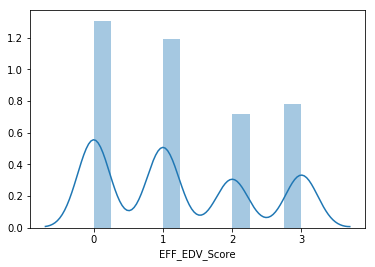

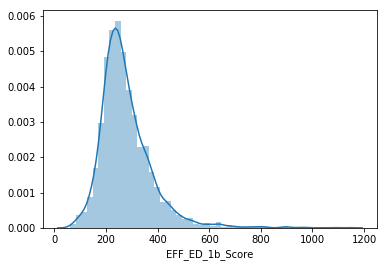

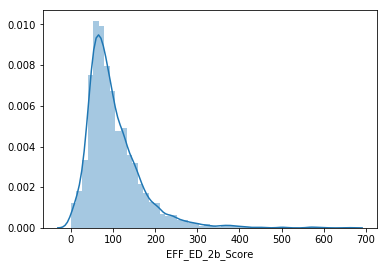

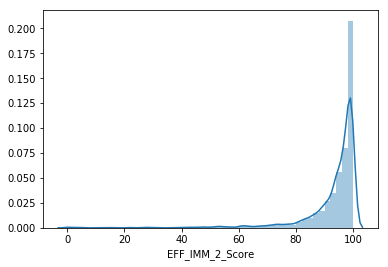

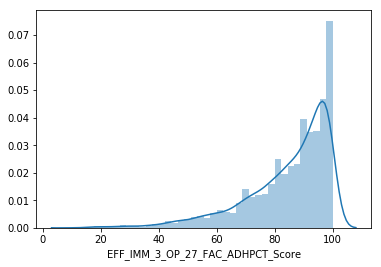

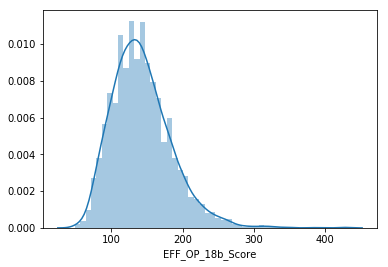

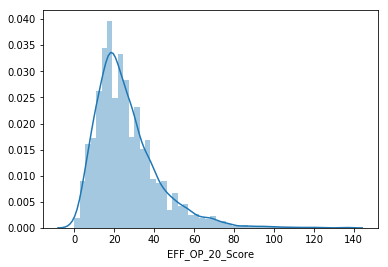

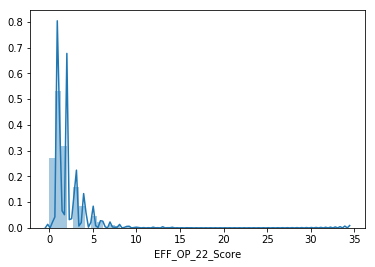

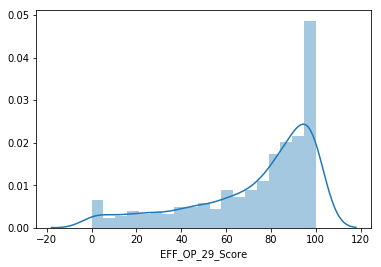

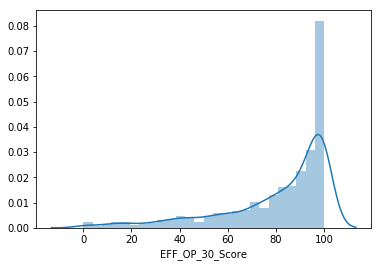

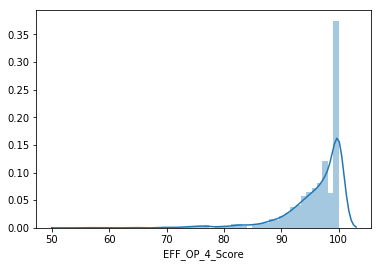

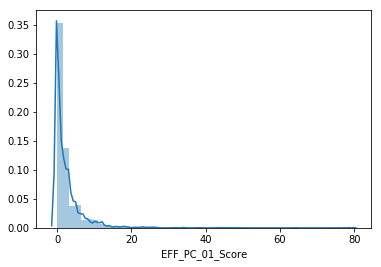

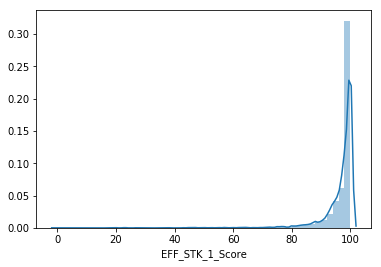

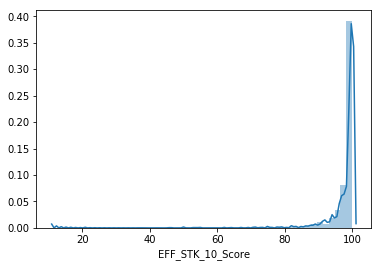

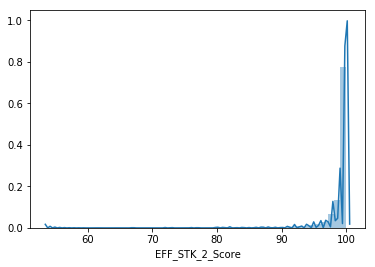

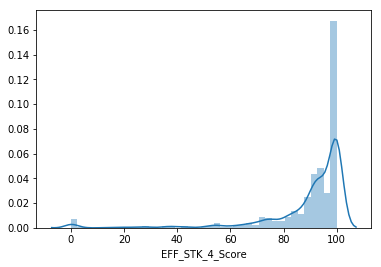

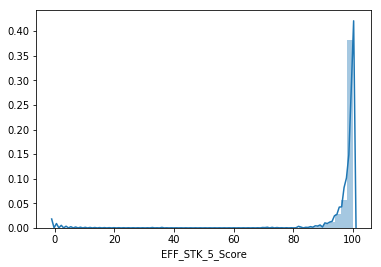

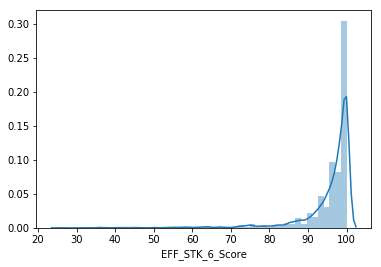

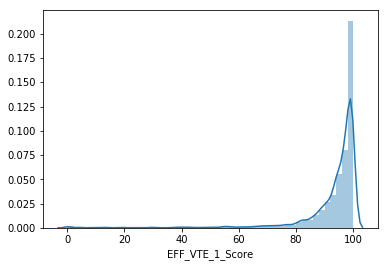

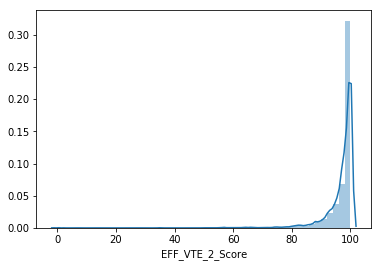

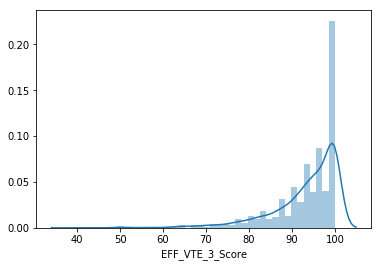

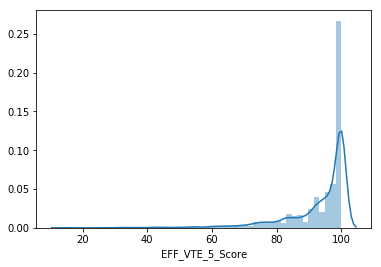

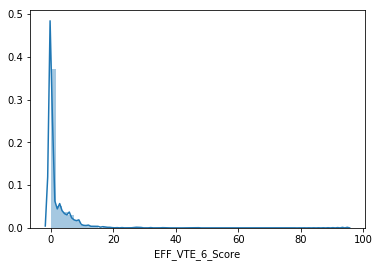

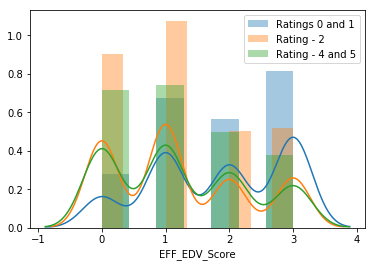

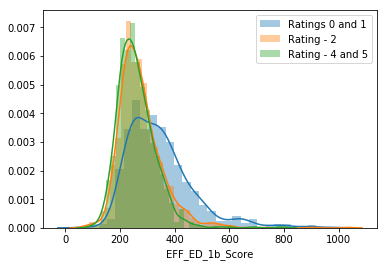

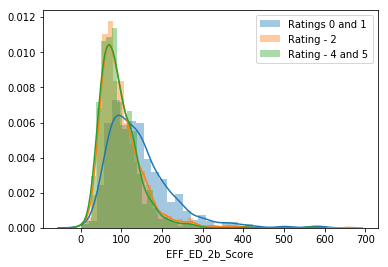

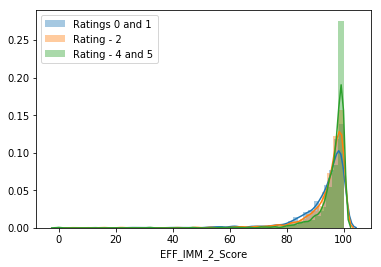

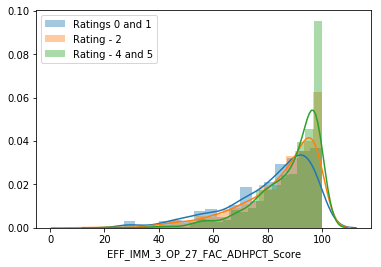

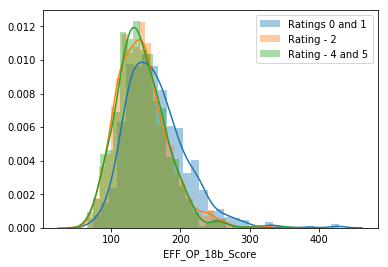

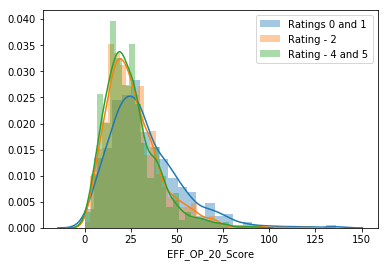

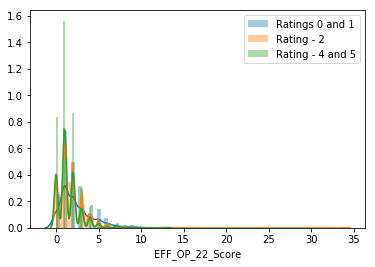

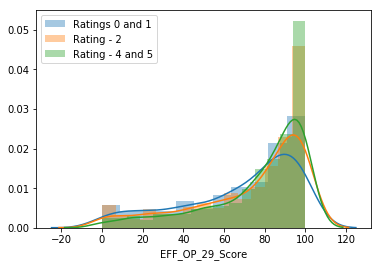

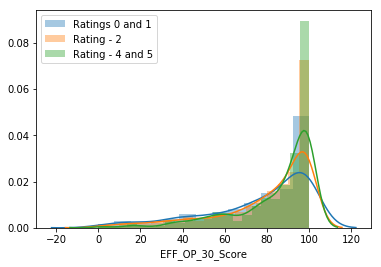

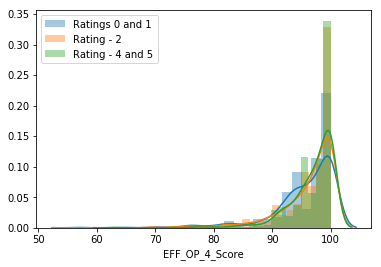

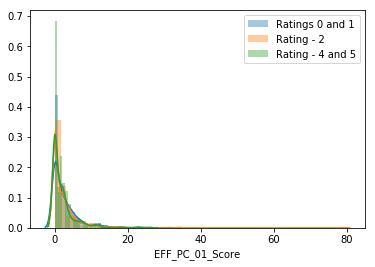

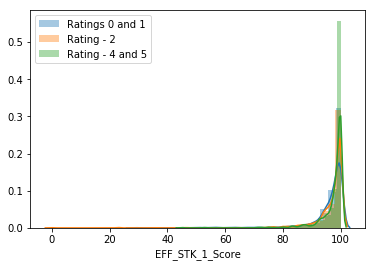

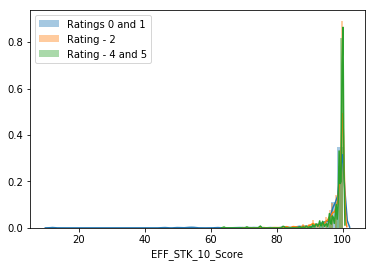

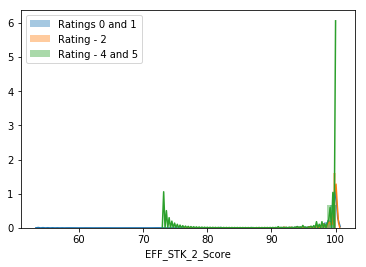

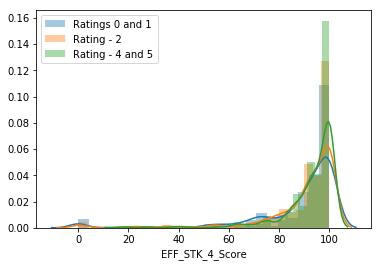

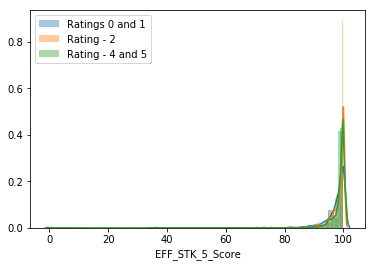

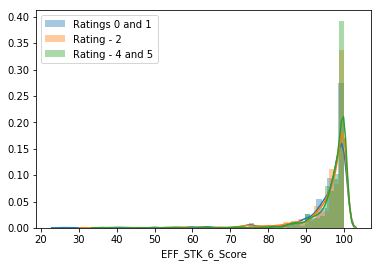

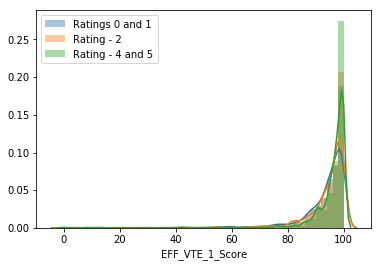

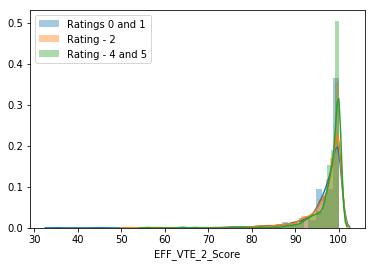

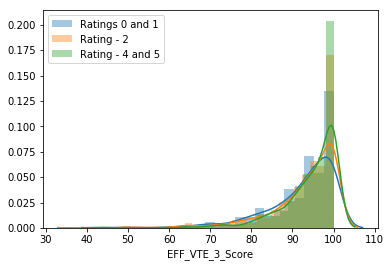

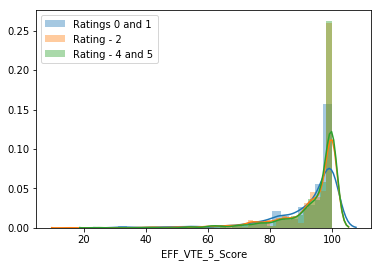

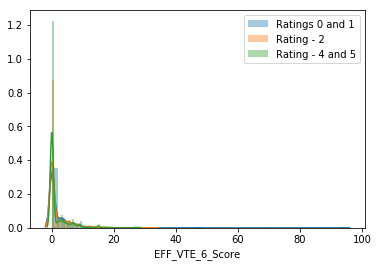

In [39]:
plot_distributions(df_eff)
plot_group_distributions(df_eff, master_data)

* Only **EB_1b**, **OP_20** and **OP_21** have strong impact on rating, most of the other features related timeliness have very impact on overall ratings
* We need to invert ['EDV', 'ED_1b', 'ED_2b', 'OP_18b', 'OP_20', 'OP_22', 'PC_01', 'VTE_6'] so that higher is better

In [40]:
for m in ['EDV', 'ED_1b', 'ED_2b', 'OP_18b', 'OP_20', 'OP_22', 'PC_01', 'VTE_6']:
    col = "EFF_{}_Score".format(m)
    df_eff[col] = -1*df_eff[col]

In [41]:
### Timeliness
df_time = df_time_eff.loc[df_time_eff["Measure Name"].isin(time_measures)]
df_time.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Condition,Measure ID,Measure Name,Score,Sample,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,AMI_7a,Fibrinolytic Therapy Received Within 30 Minute...,Not Available,Not Available,7 - No cases met the criteria for this measure.,01/01/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,AMI_8a,Primary PCI Received Within 90 Minutes of Hosp...,92,24,3 - Results are based on a shorter time period...,01/01/2015,09/30/2015
9,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,OP_1,Median Time to Fibrinolysis,Not Available,Not Available,3 - Results are based on a shorter time period...,01/01/2015,12/31/2015
11,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,OP_2,Fibrinolytic Therapy Received Within 30 Minute...,Not Available,Not Available,3 - Results are based on a shorter time period...,01/01/2015,12/31/2015
13,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,OP_21,Median time to pain med,99,111,NaN,01/01/2015,12/31/2015


In [42]:
df_time = pivot_data(df_time, measure_col="Measure ID", score_col="Score")
df_time = df_time.astype(float)
df_time.columns = df_time.columns.map("TIME_{0}".format)
df_time.head()

,TIME_AMI_7a_Score,TIME_AMI_8a_Score,TIME_OP_1_Score,TIME_OP_2_Score,TIME_OP_21_Score,TIME_OP_3b_Score,TIME_OP_5_Score,TIME_SCIP_INF_1_Score,TIME_SCIP_INF_3_Score,TIME_SCIP_VTE_2_Score
Provider ID,,,,,,,,,,
10001,NaN,92.0,NaN,NaN,99.0,NaN,NaN,100.0,99.0,100.0
10005,NaN,NaN,NaN,NaN,60.0,NaN,12.0,100.0,100.0,100.0
10006,NaN,NaN,NaN,NaN,58.0,NaN,NaN,NaN,NaN,NaN
10007,NaN,NaN,NaN,NaN,90.0,NaN,7.0,100.0,94.0,100.0
10008,NaN,NaN,NaN,NaN,49.0,NaN,NaN,NaN,NaN,NaN


In [43]:
df_time.isnull().mean()

TIME_AMI_7a_Score        0.999727
TIME_AMI_8a_Score        0.959530
TIME_OP_1_Score          0.978398
TIME_OP_2_Score          0.978398
TIME_OP_21_Score         0.094066
TIME_OP_3b_Score         0.892535
TIME_OP_5_Score          0.386382
TIME_SCIP_INF_1_Score    0.846049
TIME_SCIP_INF_3_Score    0.851518
TIME_SCIP_VTE_2_Score    0.850971
dtype: float64

In [44]:
imp_measures = df_time.columns[df_time.isnull().mean() < 0.80]
print("Measure with less than 80% missing data are", len(imp_measures))
df_time = df_time[imp_measures]

Measure with less than 80% missing data are 2


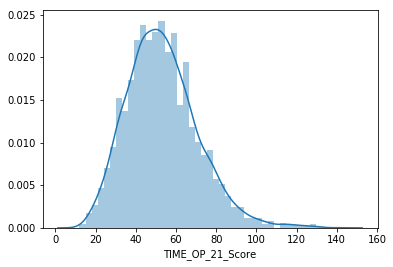

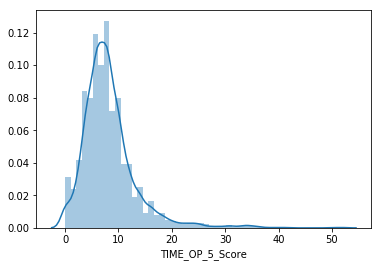

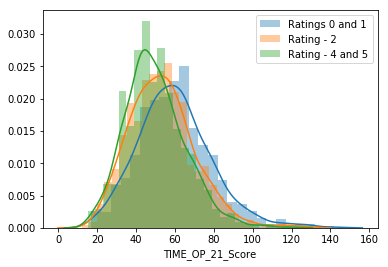

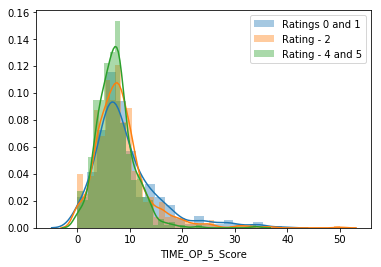

In [45]:
plot_distributions(df_time)
plot_group_distributions(df_time, master_data)

* **Both are good indicators**
* **Need to invert both**

In [46]:
df_time = -1*df_time

## Patient Experience

In [48]:
df_exp = pd.read_csv("HCAHPS - Hospital.csv", encoding="latin-1")
df_exp.drop(["Address", "City", "State", "ZIP Code", "County Name"], axis=1, inplace=True)
df_exp.head(10)

,Provider ID,Hospital Name,Phone Number,HCAHPS Measure ID,HCAHPS Question,HCAHPS Answer Description,Patient Survey Star Rating,Patient Survey Star Rating Footnote,HCAHPS Answer Percent,HCAHPS Answer Percent Footnote,HCAHPS Linear Mean Value,Number of Completed Surveys,Number of Completed Surveys Footnote,Survey Response Rate Percent,Survey Response Rate Percent Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,3347938701,H_STAR_RATING,Summary star rating,Summary star rating,3,NaN,Not Applicable,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,3347938701,H_CLEAN_HSP_A_P,Patients who reported that their room and bath...,"Room was ""always"" clean",Not Applicable,NaN,66,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,3347938701,H_CLEAN_HSP_SN_P,Patients who reported that their room and bath...,"Room was ""sometimes"" or ""never"" clean",Not Applicable,NaN,12,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,3347938701,H_CLEAN_HSP_U_P,Patients who reported that their room and bath...,"Room was ""usually"" clean",Not Applicable,NaN,22,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,3347938701,H_CLEAN_LINEAR_SCORE,Cleanliness - linear mean score,Cleanliness - linear mean score,Not Applicable,NaN,Not Applicable,NaN,84,1194,NaN,27,NaN,01/01/2015,12/31/2015
5,10001,SOUTHEAST ALABAMA MEDICAL CENTER,3347938701,H_CLEAN_STAR_RATING,Cleanliness - star rating,Cleanliness - star rating,2,NaN,Not Applicable,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
6,10001,SOUTHEAST ALABAMA MEDICAL CENTER,3347938701,H_COMP_1_A_P,"Patients who reported that their nurses ""Alway...","Nurses ""always"" communicated well",Not Applicable,NaN,76,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
7,10001,SOUTHEAST ALABAMA MEDICAL CENTER,3347938701,H_COMP_1_LINEAR_SCORE,Nurse communication - linear mean score,Nurse communication - linear mean score,Not Applicable,NaN,Not Applicable,NaN,90,1194,NaN,27,NaN,01/01/2015,12/31/2015
8,10001,SOUTHEAST ALABAMA MEDICAL CENTER,3347938701,H_COMP_1_SN_P,"Patients who reported that their nurses ""Somet...","Nurses ""sometimes"" or ""never"" communicated well",Not Applicable,NaN,6,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
9,10001,SOUTHEAST ALABAMA MEDICAL CENTER,3347938701,H_COMP_1_STAR_RATING,Nurse communication - star rating,Nurse communication - star rating,3,NaN,Not Applicable,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015


**The hospital experience file has different format compared to other files. Also, the scores are distributed across 3 columns. For `Star Rating` scores is in `Patient Survey Star Rating`. `Cleanliness` scores are in `Answer Description`. `Linear value` related scores are in `HCAHPS Linear Mean Value`**

**We will start by only taking Star Ratings**

In [49]:
df_exp["Measure ID"] = df_exp["HCAHPS Measure ID"].copy()
df_exp["Score"] = df_exp["Patient Survey Star Rating"].copy()
df_exp = df_exp.loc[df_exp["HCAHPS Measure ID"].str.contains("STAR_RATING")]

In [50]:
print("No. of unique measures", df_exp["Measure ID"].nunique())
df_exp["HCAHPS Question"].unique()

No. of unique measures 12


array(['Summary star rating', 'Cleanliness - star rating',
       'Nurse communication - star rating',
       'Doctor communication - star rating',
       'Staff responsiveness - star rating',
       'Pain management - star rating',
       'Communication about medicines - star rating',
       'Discharge information - star rating',
       'Care transition - star rating',
       'Overall hospital rating - star rating', 'Quietness - star rating',
       'Recommend hospital - star rating'], dtype=object)

In [51]:
df_exp = pivot_data(df_exp, measure_col="Measure ID", score_col="Score")
df_exp.columns = df_exp.columns.map("EXP_{0}".format)
df_exp = df_exp.astype(float)
df_exp.head()

,EXP_H_CLEAN_STAR_RATING_Score,EXP_H_COMP_1_STAR_RATING_Score,EXP_H_COMP_2_STAR_RATING_Score,EXP_H_COMP_3_STAR_RATING_Score,EXP_H_COMP_4_STAR_RATING_Score,EXP_H_COMP_5_STAR_RATING_Score,EXP_H_COMP_6_STAR_RATING_Score,EXP_H_COMP_7_STAR_RATING_Score,EXP_H_HSP_RATING_STAR_RATING_Score,EXP_H_QUIET_STAR_RATING_Score,EXP_H_RECMND_STAR_RATING_Score,EXP_H_STAR_RATING_Score
Provider ID,,,,,,,,,,,,
10001,2.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0
10005,2.0,3.0,4.0,3.0,3.0,3.0,4.0,2.0,4.0,4.0,3.0,3.0
10006,2.0,3.0,4.0,3.0,3.0,3.0,2.0,2.0,2.0,4.0,2.0,3.0
10007,3.0,3.0,5.0,4.0,4.0,4.0,3.0,3.0,3.0,5.0,3.0,4.0
10011,1.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,3.0,3.0,3.0


In [52]:
df_exp.isnull().mean()

EXP_H_CLEAN_STAR_RATING_Score         0.0
EXP_H_COMP_1_STAR_RATING_Score        0.0
EXP_H_COMP_2_STAR_RATING_Score        0.0
EXP_H_COMP_3_STAR_RATING_Score        0.0
EXP_H_COMP_4_STAR_RATING_Score        0.0
EXP_H_COMP_5_STAR_RATING_Score        0.0
EXP_H_COMP_6_STAR_RATING_Score        0.0
EXP_H_COMP_7_STAR_RATING_Score        0.0
EXP_H_HSP_RATING_STAR_RATING_Score    0.0
EXP_H_QUIET_STAR_RATING_Score         0.0
EXP_H_RECMND_STAR_RATING_Score        0.0
EXP_H_STAR_RATING_Score               0.0
dtype: float64

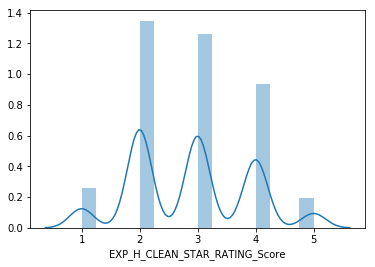

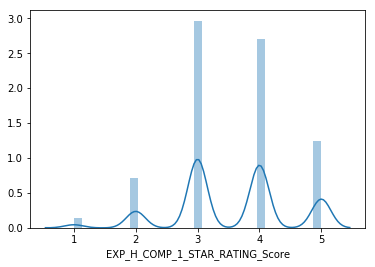

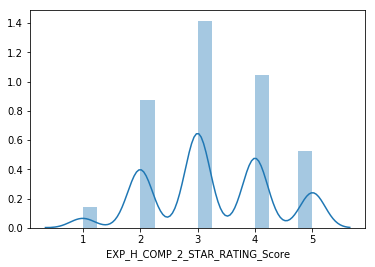

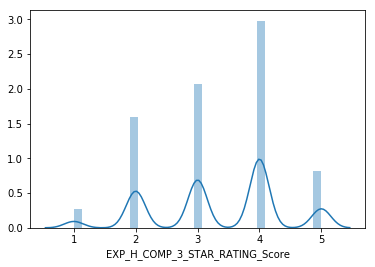

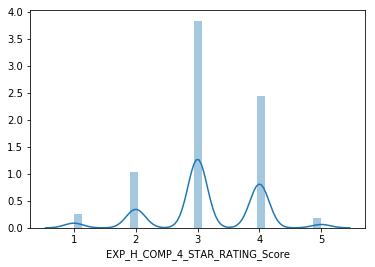

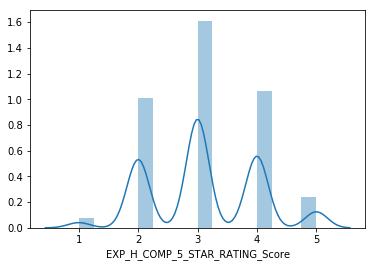

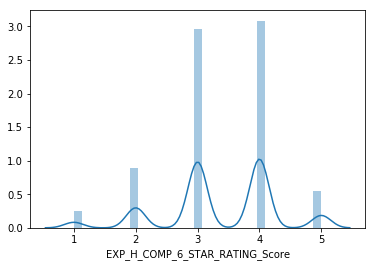

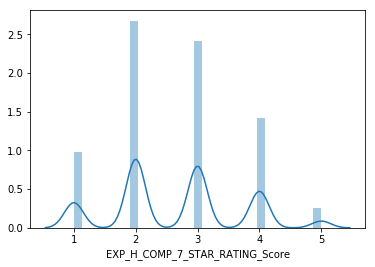

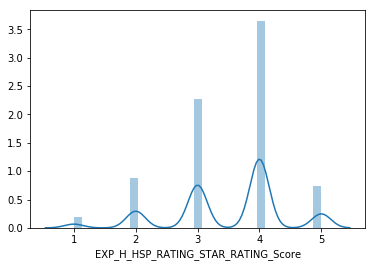

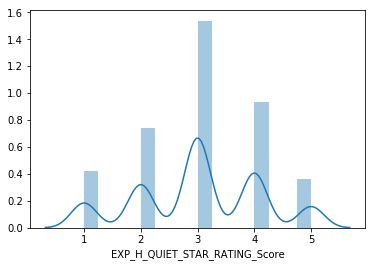

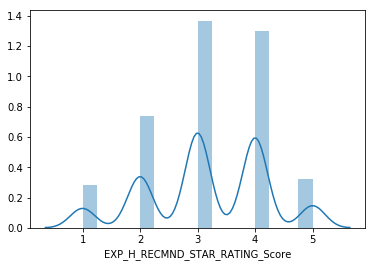

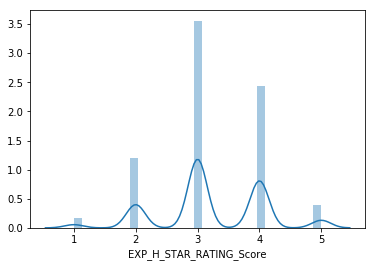

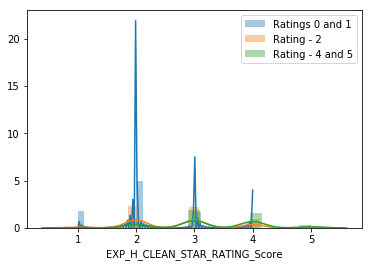

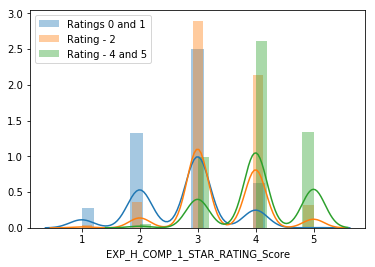

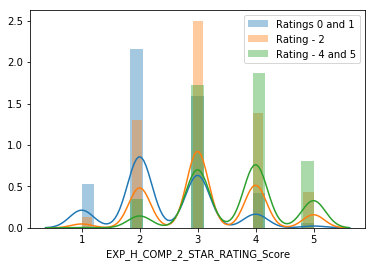

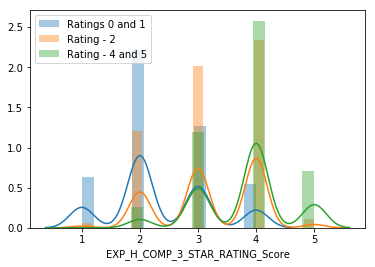

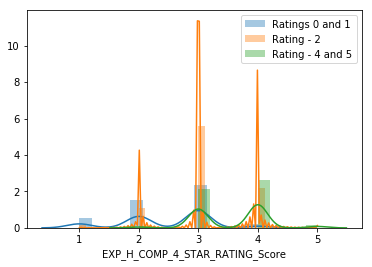

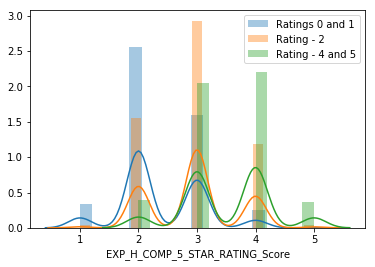

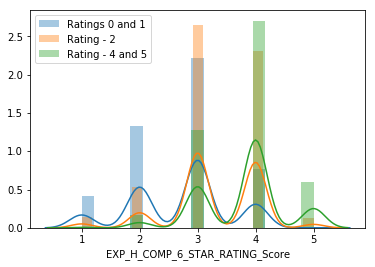

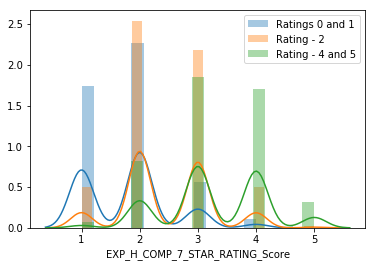

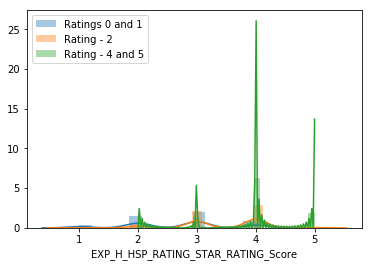

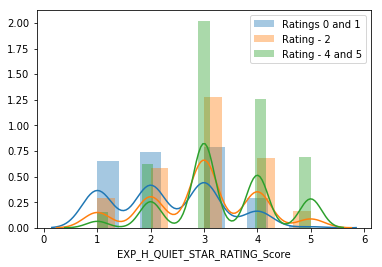

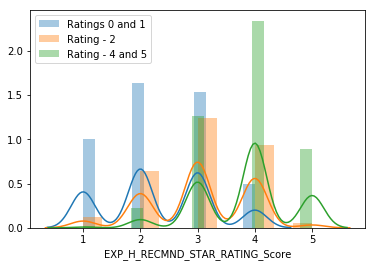

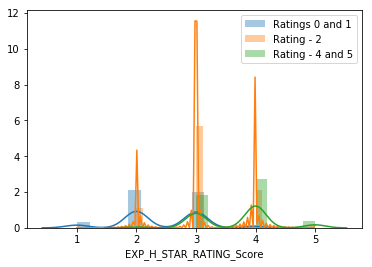

In [53]:
plot_distributions(df_exp)
plot_group_distributions(df_exp, master_data)

**All star ratings seem to have good corelation with overall ratings**

## Medical Imaging

In [54]:
df_med = pd.read_csv("Outpatient Imaging Efficiency - Hospital.csv")
df_med.head(5)

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure ID,Measure Name,Score,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_10,Abdomen CT Use of Contrast Material,6.4,NaN,07/01/2014,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_11,Thorax CT Use of Contrast Material,0.9,NaN,07/01/2014,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_13,Outpatients who got cardiac imaging stress tes...,7.1,NaN,07/01/2014,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_14,Outpatients with brain CT scans who got a sinu...,2.4,NaN,07/01/2014,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_8,MRI Lumbar Spine for Low Back Pain,38.1,NaN,07/01/2014,06/30/2015


In [55]:
print("No. of unique measures", df_med["Measure ID"].nunique())
df_med["Measure Name"].unique()

No. of unique measures 6


array(['Abdomen CT Use of Contrast Material',
       'Thorax CT Use of Contrast Material',
       'Outpatients who got cardiac imaging stress tests before low-risk outpatient surgery',
       'Outpatients with brain CT scans who got a sinus CT scan at the same time',
       'MRI Lumbar Spine for Low Back Pain',
       'Mammography Follow-up Rates'], dtype=object)

In [56]:
df_med = pivot_data(df_med, measure_col="Measure ID", score_col="Score")
df_med = df_med.astype(float)
df_med.columns = df_med.columns.map("MED_{0}".format)
df_med.head()

,MED_OP_10_Score,MED_OP_11_Score,MED_OP_13_Score,MED_OP_14_Score,MED_OP_8_Score,MED_OP_9_Score
Provider ID,,,,,,
10001,6.4,0.9,7.1,2.4,38.1,6.9
10005,13.3,10.2,5.3,4.0,42.8,5.1
10006,11.8,4.6,0.0,4.6,45.6,9.1
10007,24.3,6.1,NaN,NaN,NaN,20.7
10008,3.6,NaN,NaN,0.6,NaN,8.2


In [57]:
df_med.isnull().mean()

MED_OP_10_Score    0.040708
MED_OP_11_Score    0.114724
MED_OP_13_Score    0.409728
MED_OP_14_Score    0.390960
MED_OP_8_Score     0.597145
MED_OP_9_Score     0.134549
dtype: float64

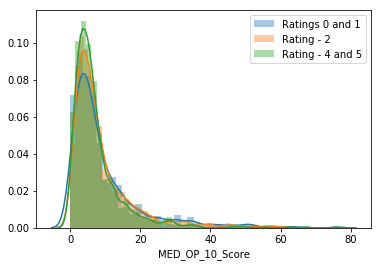

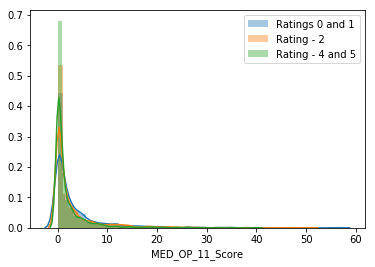

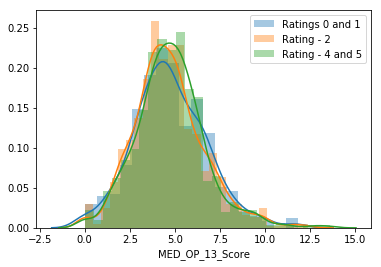

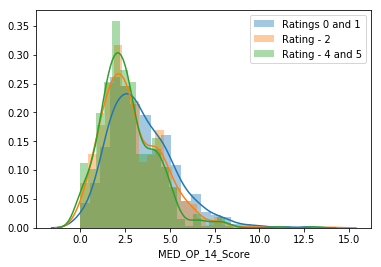

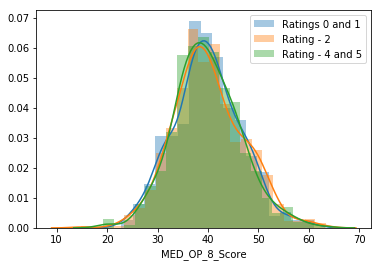

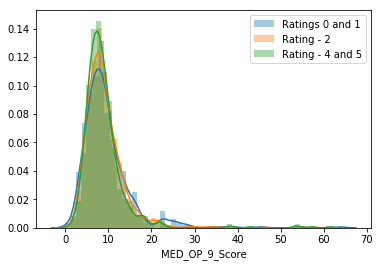

In [58]:
#plot_distributions(df_med)
plot_group_distributions(df_med, master_data)

**Imaging efficieny measures don't impact rating much**

In [59]:
df_med = -1*df_med

## Safety of care

In [60]:
df_safety = pd.read_csv("Complications - Hospital.csv", encoding="latin-1")
df_safety.head(5)

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of complications for hip/knee replacement...,COMP_HIP_KNEE,No Different than the National Rate,331,3.8,2.6,5.5,NaN,04/01/2012,03/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Serious blood clots after surgery,PSI_12_POSTOP_PULMEMB_DVT,No Different than the National Rate,4549,3.32,1.25,5.38,NaN,07/01/2013,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Blood stream infection after surgery,PSI_13_POST_SEPSIS,No Different than the National Rate,578,5.72,0.00,11.48,NaN,07/01/2013,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,A wound that splits open after surgery on the...,PSI_14_POSTOP_DEHIS,No Different than the National Rate,445,2.72,0.65,4.79,NaN,07/01/2013,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Accidental cuts and tears from medical treatment,PSI_15_ACC_LAC,No Different than the National Rate,16429,1.35,0.76,1.95,NaN,07/01/2013,06/30/2015


In [61]:
print("No. of unique measures", df_safety["Measure ID"].nunique())
df_safety["Measure Name"].unique()

No. of unique measures 11


array(['Rate of complications for hip/knee replacement patients',
       'Serious blood clots after surgery',
       'Blood stream infection after surgery',
       'A wound that splits open  after surgery on the abdomen or pelvis',
       'Accidental cuts and tears from medical treatment',
       'Pressure sores',
       'Deaths among Patients with Serious Treatable Complications after Surgery',
       'Collapsed lung due to medical treatment',
       'Infections from a large venous catheter',
       'Broken hip from a fall after surgery', 'Serious complications'],
      dtype=object)

In [62]:
df_safety = pivot_data(df_safety, measure_col="Measure ID", score_col="Score")
df_safety = df_safety.astype(float)
df_safety.columns = df_safety.columns.map("SAFETY_{0}".format)
df_safety.head()

,SAFETY_COMP_HIP_KNEE_Score,SAFETY_PSI_12_POSTOP_PULMEMB_DVT_Score,SAFETY_PSI_13_POST_SEPSIS_Score,SAFETY_PSI_14_POSTOP_DEHIS_Score,SAFETY_PSI_15_ACC_LAC_Score,SAFETY_PSI_3_ULCER_Score,SAFETY_PSI_4_SURG_COMP_Score,SAFETY_PSI_6_IAT_PTX_Score,SAFETY_PSI_7_CVCBI_Score,SAFETY_PSI_8_POST_HIP_Score,SAFETY_PSI_90_SAFETY_Score
Provider ID,,,,,,,,,,,
10001,3.8,3.32,5.72,2.72,1.35,0.07,168.26,0.36,0.12,0.06,0.68
10005,3.0,5.63,9.18,2.11,1.25,0.14,179.05,0.47,0.11,0.06,0.85
10006,3.8,3.85,NaN,2.50,1.93,0.09,198.33,0.41,0.24,0.06,0.91
10007,NaN,4.57,9.89,NaN,1.20,0.35,NaN,0.40,0.16,0.06,0.79
10008,NaN,NaN,NaN,NaN,1.41,0.45,NaN,0.41,0.17,NaN,0.90


In [63]:
df_safety.isnull().mean()

SAFETY_COMP_HIP_KNEE_Score                0.221010
SAFETY_PSI_12_POSTOP_PULMEMB_DVT_Score    0.143513
SAFETY_PSI_13_POST_SEPSIS_Score           0.337543
SAFETY_PSI_14_POSTOP_DEHIS_Score          0.270953
SAFETY_PSI_15_ACC_LAC_Score               0.081803
SAFETY_PSI_3_ULCER_Score                  0.116533
SAFETY_PSI_4_SURG_COMP_Score              0.478186
SAFETY_PSI_6_IAT_PTX_Score                0.080941
SAFETY_PSI_7_CVCBI_Score                  0.084099
SAFETY_PSI_8_POST_HIP_Score               0.177382
SAFETY_PSI_90_SAFETY_Score                0.074627
dtype: float64

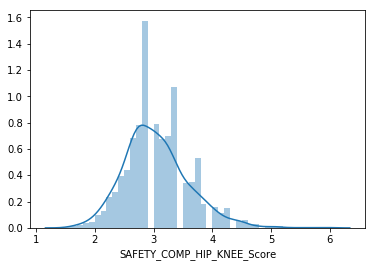

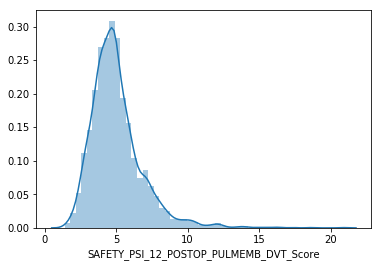

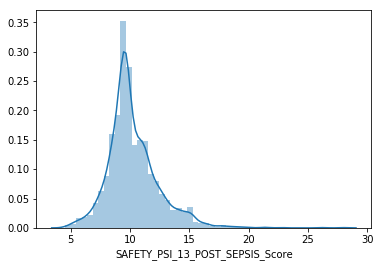

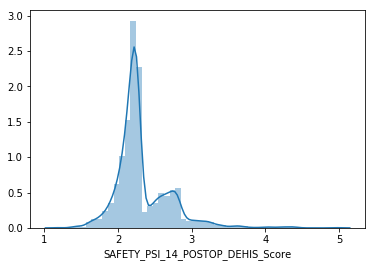

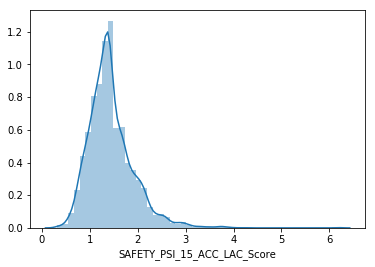

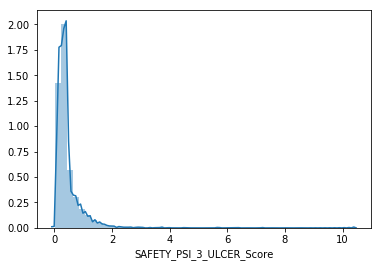

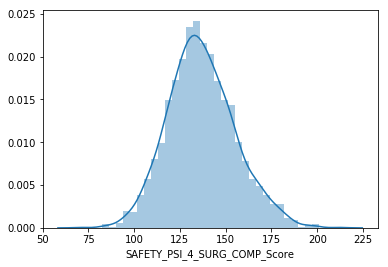

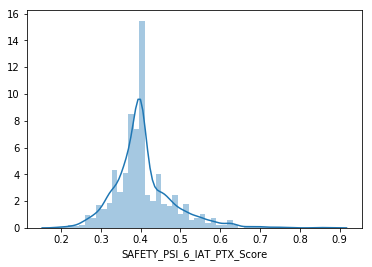

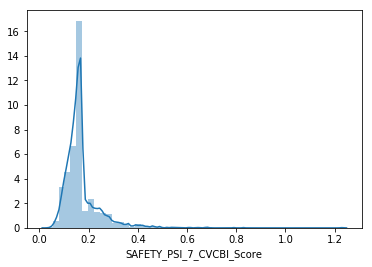

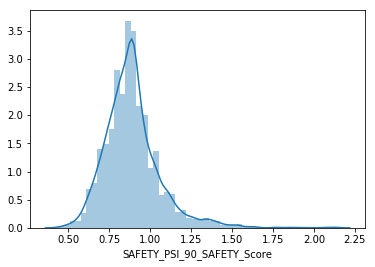

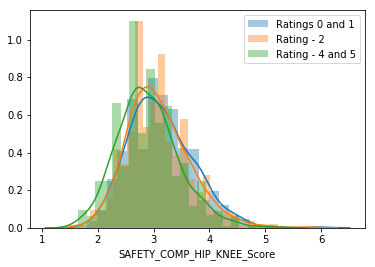

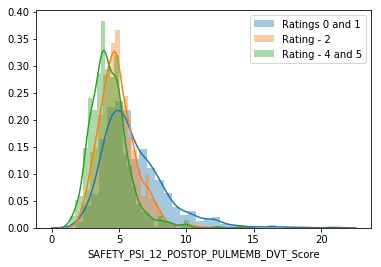

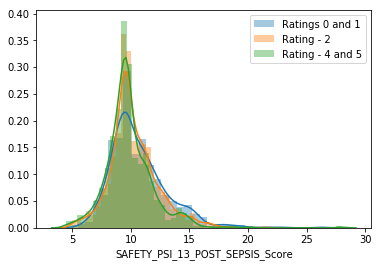

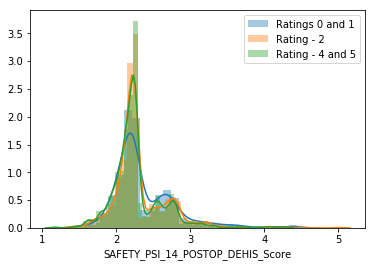

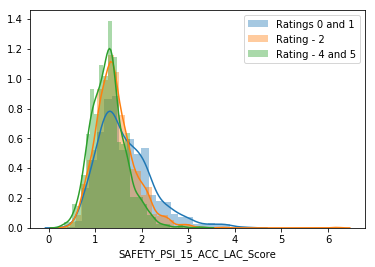

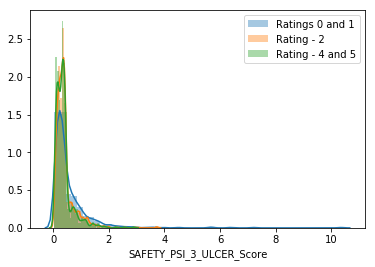

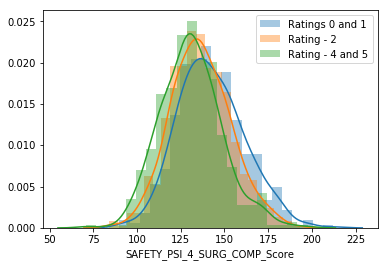

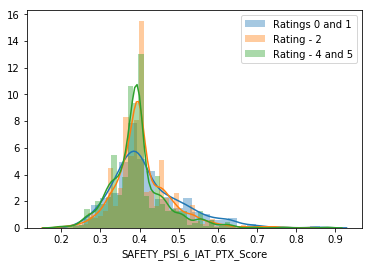

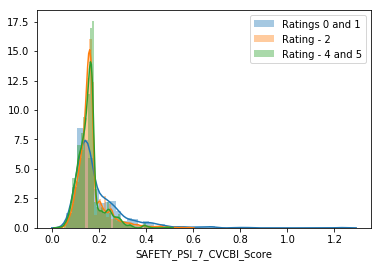

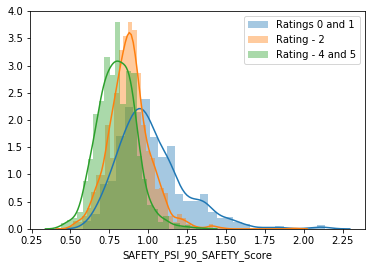

In [64]:
del df_safety["SAFETY_PSI_8_POST_HIP_Score"]
plot_distributions(df_safety)
plot_group_distributions(df_safety, master_data)

**PSI 90 SAFETY** score strongy impacts overall rating

There are additional infection related measures which also fall under safety of care

In [66]:
df_safety2 = pd.read_csv("Healthcare Associated Infections - Hospital.csv")
df_safety2.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Score,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Lower Confidence Limit,HAI_1_CI_LOWER,NaN,1.03,NaN,1/1/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Upper Confidence Limit,HAI_1_CI_UPPER,NaN,2.765,NaN,1/1/2015,12/31/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Number of Device Days,HAI_1_DOPC_DAYS,NaN,7117,NaN,1/1/2015,12/31/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Predicted Cases,HAI_1_ELIGCASES,NaN,9.198,NaN,1/1/2015,12/31/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Observed Cases,HAI_1_NUMERATOR,NaN,16,NaN,1/1/2015,12/31/2015


In [67]:
infection_measures = set(['Central line-associated bloodstream infections (CLABSI) in ICUs and select wards',
       'Central line-associated blood stream infections (CLABSI) in ICUs only',
       'Catheter-associated urinary tract infections (CAUTI) in ICUs and select wards',
       'Catheter-Associated Urinary Tract Infections (CAUTI) in ICUs only',
       'Surgical Site Infection from colon surgery (SSI: Colon)',
       'Surgical Site Infection from abdominal hysterectomy (SSI: Hysterectomy)',
       'Methicillin-resistant Staphylococcus Aureus (MRSA) Blood Laboratory-identified Events (Bloodstream infections)',
       'Clostridium difficile (C.diff.) Laboratory-identified Events (Intestinal infections)'])
df_safety2 = df_safety2.loc[df_safety2["Measure Name"].isin(infection_measures)]

In [68]:
df_safety2 = pivot_data(df_safety2, measure_col="Measure ID", score_col="Score")
df_safety2 = df_safety2.astype(float)
df_safety2.columns = df_safety2.columns.map("SAFETY_{0}".format)
df_safety2.head()

,SAFETY_HAI_1_SIR_Score,SAFETY_HAI_1a_SIR_Score,SAFETY_HAI_2_SIR_Score,SAFETY_HAI_2a_SIR_Score,SAFETY_HAI_3_SIR_Score,SAFETY_HAI_4_SIR_Score,SAFETY_HAI_5_SIR_Score,SAFETY_HAI_6_SIR_Score
Provider ID,,,,,,,,
10001,1.740,2.433,1.427,2.307,1.870,0.0,0.422,0.787
10005,1.062,0.648,0.456,0.698,0.386,NaN,1.388,0.405
10006,0.341,0.443,0.641,0.801,0.310,NaN,1.261,0.513
10007,NaN,NaN,0.000,NaN,NaN,NaN,NaN,0.000
10008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.585


In [69]:
df_safety2.isnull().mean()

SAFETY_HAI_1_SIR_Score     0.287642
SAFETY_HAI_1a_SIR_Score    0.399220
SAFETY_HAI_2_SIR_Score     0.133473
SAFETY_HAI_2a_SIR_Score    0.320336
SAFETY_HAI_3_SIR_Score     0.387223
SAFETY_HAI_4_SIR_Score     0.743251
SAFETY_HAI_5_SIR_Score     0.451110
SAFETY_HAI_6_SIR_Score     0.018596
dtype: float64

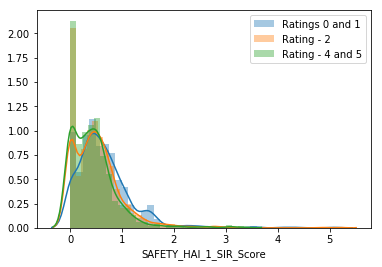

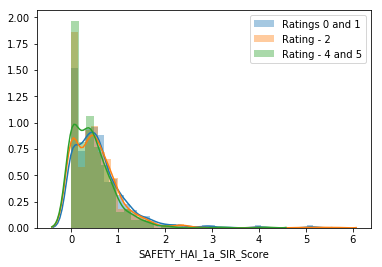

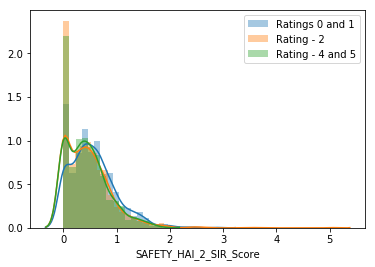

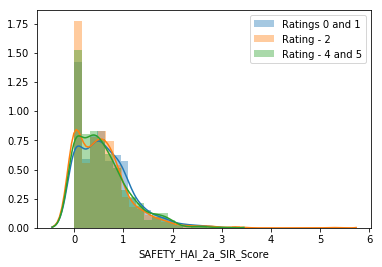

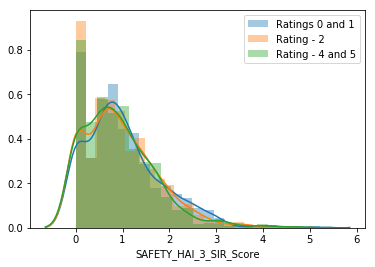

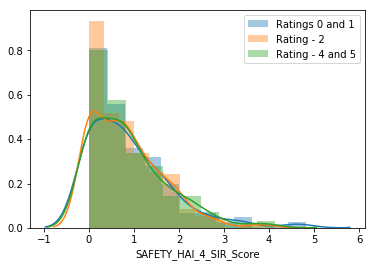

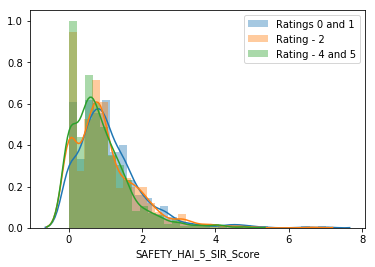

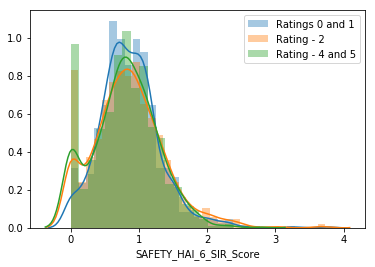

In [70]:
plot_group_distributions(df_safety2, master_data)

In [71]:
#Merge all safety measures
df_safety = df_safety.join(df_safety2, on="Provider ID")
df_safety = -1*df_safety # invert as measures are inversely corelated with ratings

Now that we have loaded and cleaned extra data, we can merge all features.

In [72]:
df_master = df_mort.join(df_readm, on="Provider ID").\
                    join(df_time, on="Provider ID").\
                    join(df_eff, on="Provider ID").\
                    join(df_exp, on="Provider ID").\
                    join(df_safety, on="Provider ID").\
                    join(df_med, on="Provider ID")
df_master.shape

(3061, 79)

In [73]:
features = [col for col in df_master.columns if col not in ["Hospital Type",
                                                            "Hospital overall rating"]]
df_master[features].to_csv("additional_features.csv", index=False)